In [2]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from pytorchtools import EarlyStopping
import time
import argparse
import matplotlib.pyplot as plt
torch.cuda.is_available() #check cuda

True

In [4]:
#Load the POI dataset
df=pd.read_csv('./poi_clean.csv').drop(['Unnamed: 0'],axis=1)
df=df.drop_duplicates()
#setting the training and testing set
dtrain,dtest=train_test_split(df,test_size=0.1,random_state=27)
#dataset for costco
tr_idxs=dtrain.values[:,0:3]
tr_vals=dtrain.values[:,-1]
te_idxs=dtest.values[:,0:3]
te_vals=dtest.values[:,-1]
shape=(2321, 5596, 1600)

In [10]:
class Experiment:
    
    def __init__(self, learning_rate=0.0005,shape=(3,4,5,6),rank=(2,3,4,5),validation_split=0.1,
                 num_iterations=500, cuda=True, 
                 model='ML1',batch_size=128,patience=10,core=(2,3,4),ccore=(2,3,4),
                 tr_idxs=1,tr_vals=1,
                 lambda_l1=1e-3,lambda_l2=1e-3,regularization='L1'):
        self.learning_rate = learning_rate
        self.shape = shape
        self.rank = rank
        self.core = core
        self.ccore = ccore
        self.num_iterations = num_iterations
        self.cuda = cuda
        self.model = model
        self.batch_size = batch_size
        self.patience=patience
        self.tr_idxs=tr_idxs
        self.tr_vals=tr_vals
        self.validation_split=validation_split
        self.regularization=regularization
        self.lambda_l1=lambda_l1
        self.lambda_l2=lambda_l2
             
    def save_models(epoch):
        torch.save(model.state_dict(), "./adclickmodel_{}.model".format(epoch))
        print("Chekcpoint saved")
        
    def get_index(self, data, idx):
        batch = data[idx:idx+self.batch_size,:]
        targets = data[idx:idx+self.batch_size,-1]
        targets = torch.FloatTensor(targets)
        if self.cuda:
           targets = targets.cuda()
        return np.array(batch), targets

    def evaluate(self, model, idxs,vals):
        with torch.no_grad():
            model.eval()
            #prob_list=[]
            prediction_list=[]
            target_list=[]
            losses=[]
            rmse_list=[]
            mae_list=[]
            
            data=np.concatenate((idxs,vals.reshape(-1,1)),axis=1)
            test_data_idxs = data
            print("Number of data points: %d" % len(test_data_idxs))
        
            for i in range(0, len(test_data_idxs),self.batch_size):
                data_batch, targets = self.get_index(test_data_idxs, i)
                u_idx = torch.tensor(data_batch[:,0].astype(int))
                v_idx = torch.tensor(data_batch[:,1].astype(int))
                w_idx = torch.tensor(data_batch[:,2].astype(int))
                if self.cuda:
                    u_idx = u_idx.cuda()
                    v_idx = v_idx.cuda()
                    w_idx = w_idx.cuda()
                predictions = model.forward(u_idx, v_idx,w_idx) 
            
                prediction_list=prediction_list+predictions.cpu().tolist() 
                target_list=target_list+targets.cpu().tolist()

                loss = model.loss(predictions, targets)
                losses.append(loss.item())
                        
            val_loss=np.mean(losses)  
            val_mae=mae(target_list, prediction_list)
            val_rmse=rmse(target_list, prediction_list)
            val_mape=mape(target_list, prediction_list)

            return prediction_list,val_loss,val_rmse,val_mae,val_mape 
    
    def train_and_eval(self):
        train_losses=[]
        val_losses=[]
        val_rmses=[]
        val_maes=[]
        val_mapes=[]
        
        print("Training the NMTucker model...")
        print("batch size is {0}".format(self.batch_size))
        train,val=train_val_split(self.tr_idxs,self.tr_vals,self.validation_split)
        train_data_idxs = train
        print("Number of training data points: %d" % len(train_data_idxs))
        if self.model=='ML1': #NMTucker-L1 
           model = ML1(self.shape, self.rank)
        elif self.model=="ML2": #NMTucker-L2
           model = ML2(self.shape, self.rank,self.core)
        elif self.model=="ML3": #NMTucker-L3
           model = ML3(self.shape, self.rank,self.core,self.ccore)
             
        if self.cuda:
            model.cuda()
        model.init()
        opt = torch.optim.Adam(model.parameters(), lr=self.learning_rate)

        print("Starting training...")
        # initialize the early_stopping object
        early_stopping = EarlyStopping(patience=self.patience, verbose=True)
        for it in range(1, self.num_iterations+1):
            start_train = time.time()
            model.train()    
            losses = []
            np.random.shuffle(train_data_idxs)
            for j in range(0, len(train_data_idxs),self.batch_size):
                data_batch, targets = self.get_index(train_data_idxs,j)
                opt.zero_grad()
                u_idx = torch.tensor(data_batch[:,0].astype(int))
                v_idx = torch.tensor(data_batch[:,1].astype(int))
                w_idx = torch.tensor(data_batch[:,2].astype(int))  
                if self.cuda:
                    u_idx = u_idx.cuda()
                    v_idx = v_idx.cuda()
                    w_idx = w_idx.cuda()
                predictions = model.forward(u_idx, v_idx , w_idx)  
                loss = model.loss(predictions, targets)
                losses.append(loss.item())
                if self.regularization=='L1':
                    lossl1=l1_regularizer(model, self.lambda_l1)
                    loss=loss+lossl1
                elif self.regularization=='L2':
                    lossl2=l2_regularizer(model, self.lambda_l2)
                    loss=loss+lossl2
                    
                loss.backward(retain_graph=True)
                opt.step()
                
            train_loss=np.mean(losses)
            train_losses.append(train_loss)
            print(it)
            print(time.time()-start_train)    
            print(train_loss)
            
            with torch.no_grad():
                print("Validation:")
                _,val_loss,val_rmse,val_mae,val_mape= self.evaluate(model,val[:,0:3],val[:,-1]) 
                val_losses.append(val_loss)
                val_rmses.append(val_rmse)
                val_maes.append(val_mae)
                val_mapes.append(val_mape)
                
                print('val_loss:{0}'.format(val_loss))
                print('val_rmse:{0}'.format(val_rmse))
                print('val_mae:{0}'.format(val_mae))
                print('val_mape:{0}'.format(val_mape))

                # early_stopping needs the validation loss to check if it has decresed, 
                # and if it has, it will make a checkpoint of the current model
                early_stopping(val_loss, model)
                if early_stopping.early_stop:
                   print("Early stopping")
                   break
                    
        # load the last checkpoint with the best model
        model.load_state_dict(torch.load('checkpoint.pt'))
                    
        dic = dict()
        dic['train_loss'] = train_losses
        dic['val_loss']   = val_losses
        dic['val_rmse']=val_rmses
        dic['val_mae']=val_maes
        dic['val_mape']=val_mapes
        dic['model']=model
        return dic

In [8]:
import argparse
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument("--num_iterations", type=int, default=200, nargs="?",
                    help="Number of iterations.")
    parser.add_argument("--patience", type=int, default=5, nargs="?",
                    help="patience for early stop.")
    parser.add_argument("--batch_size", type=int, default=256, nargs="?",
                    help="Batch size.")
    parser.add_argument("--lr", type=float, default=1e-4, nargs="?",
                    help="Learning rate.")
    parser.add_argument("--shape", default=(2321, 5596, 1600), nargs="?",
                    help="Shape of original tensor.")
    parser.add_argument("--rank", default=(5,5,5), nargs="?",
                    help="For NMTucker-L1, NMTUcker-L2, NMtucker-L3, rank is the shape of core tensor G in the output layer.")
    parser.add_argument("--core", default=(3,3,3), nargs="?",
                    help="For NMTucker-L2 core is the shape of core tensor G1 in the first layer. For NMTucker-L3, core is the shape of core tensor G2 in the second layer")
    parser.add_argument("--ccore", default=(4,4,4), nargs="?",
                    help="For NMTucker-L3, ccore is the shape of the core tensor G1 in the first layer")
    parser.add_argument("--cuda", type=bool, default=True, nargs="?",
                    help="Whether to use cuda (GPU) or not (CPU).")  
    parser.add_argument("--validation_split", type=float, default=0.1, nargs="?",
                    help="validation split ratio")
    parser.add_argument("--model", type=str, default='ML1', nargs="?",
                    help="use which model:ML1,ML2,ML3")
    args=parser.parse_known_args()[0]

Training the TuckER model...
batch size is 128
Number of training data points: 85669
Starting training...
1
2.290464162826538
0.029310038088084158
Validation:
Number of data points: 9518
val_loss:0.027550244331359865
val_rmse:0.1664779781977841
val_mae:0.094458150322633
val_mape:58.57178085385336
Validation loss decreased (inf --> 0.027550).  Saving model ...
2
2.296863079071045
0.02689599267818701
Validation:
Number of data points: 9518
val_loss:0.025957141350954772
val_rmse:0.16164020484664426
val_mae:0.08952708254163382
val_mape:54.07300049629802
Validation loss decreased (0.027550 --> 0.025957).  Saving model ...
3
2.3087868690490723
0.024409227470047215
Validation:
Number of data points: 9518
val_loss:0.025558192276706297
val_rmse:0.16038226617192142
val_mae:0.09022888102102976
val_mape:55.39173363541826
Validation loss decreased (0.025957 --> 0.025558).  Saving model ...
4
2.291811227798462
0.021572551612200133
Validation:
Number of data points: 9518
val_loss:0.02547334546223283


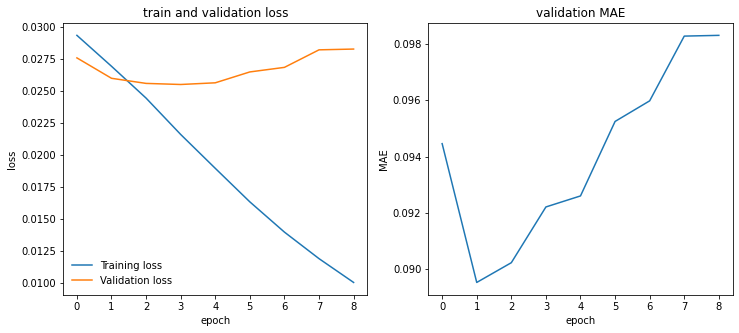

core= (5, 5, 5)
Number of data points: 95187
mse: 0.018856504550253752 rmse: 0.13729590182451432 mae: 0.07843838514374821 mape: 49.37293586269589
Number of data points: 10577
mse: 0.025784496745341515 rmse: 0.16062316767631574 mae: 0.09319484919670892 mape: 58.12780108853038


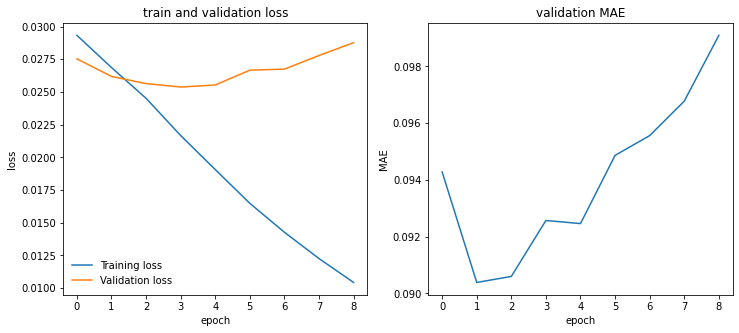

In [131]:
#relu 
le=[]
ld=[]
#rank_list=((40,40,40),(50,50,50))
core_list=((20,20,20),(5,5,5))
for core in core_list:
    ex = Experiment(num_iterations=args.num_iterations, batch_size=args.batch_size, learning_rate=1e-3, 
                            decay_rate=args.dr, shape=shape, rank=(50,50,50), core=(40,40,40),
                            ccore=args.ccore,cccore=args.cccore,cuda=args.cuda,
                            input_dropout=args.input_dropout, hidden_dropout1=args.hidden_dropout1,hidden_dropout2=args.hidden_dropout2, 
                            label_smoothing=args.label_smoothing,model='ML2',patience=args.patience,tr_idxs=tr_idxs,tr_vals=tr_vals,
                            validation_split=0.1,regularization=None)
                            
    dic=ex.train_and_eval()
    print('core=',core)
    get_result(ex,dic['model'],tr_idxs,tr_vals)
    get_result(ex,dic['model'],te_idxs,te_vals)
    le.append(ex)
    ld.append(dic)
    
for i,j,core in zip(le,ld,core_list):
    print('core=',core)
    get_result(i,j['model'],tr_idxs,tr_vals)
    get_result(i,j['model'],te_idxs,te_vals)
    plot_loss(j)

In [21]:
import os
import json
import zipfile
from pprint import pprint

import numpy as np
import tensorflow.compat.v1 as tf
import keras as k
from Utilities import cplot_loss


def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100


def mape_keras(y_true, y_pred, threshold=0.1):
    v = k.backend.clip(k.backend.abs(y_true), threshold, None)
    diff = k.backend.abs((y_true - y_pred) / v)
    return 100.0 * k.backend.mean(diff, axis=-1)

def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))

def rmse(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_pred - y_true)))

def mape(y_true, y_pred, threshold=0.1):
    v = np.clip(np.abs(y_true), threshold, None)
    diff = np.abs((y_true - y_pred) / v)
    return 100.0 * np.mean(diff, axis=-1).mean()

def transform(idxs):
    return [idxs[:, i] for i in range(idxs.shape[1])]

def set_session(device_count=None, seed=0):
    gpu_options = tf.GPUOptions(allow_growth=True)
    config = tf.ConfigProto(
            gpu_options=gpu_options, 
            device_count=device_count)

def get_metrics(model, x, y, batch_size=1024):
    yp = model.predict(x, batch_size=batch_size, verbose=1).flatten()
    return {
        "rmse": float(rmse(y, yp)), 
        "mape": float(mape(y, yp)), 
        "mae": float(mae(y, yp))
    }

In [14]:
def create_costco(shape, rank, nc):
    inputs = [k.Input(shape=(1,), dtype="int32") for i in range(len(shape))]
    embeds = [
        k.layers.Embedding(output_dim=rank, input_dim=shape[i])(inputs[i])
        for i in range(len(shape))
    ]
    x = k.layers.Concatenate(axis=1)(embeds)
    x = k.layers.Reshape(target_shape=(rank, len(shape), 1))(x)
    x = k.layers.Conv2D(
        nc, 
        kernel_size=(1, len(shape)), 
        activation="relu", 
        padding="valid"
    )(x)
    x = k.layers.Conv2D(
        nc, 
        kernel_size=(rank, 1), 
        activation="relu", 
        padding="valid"
    )(x)
    x = k.layers.Flatten()(x)
    x = k.layers.Dense(nc, activation="relu")(x)
    outputs = k.layers.Dense(1, activation="relu")(x)
    model = k.Model(inputs=inputs, outputs=outputs)

    return model

/home/dan/.local/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 85668 samples, validate on 9519 samples
Epoch 1/50
85668/85668 [==============================] - 2s 24us/step - loss: 0.0306 - mae: 0.1008 - mape_keras: 57.6453 - val_loss: 0.0249 - val_mae: 0.0899 - val_mape_keras: 53.5442
Epoch 2/50
 7936/85668 [=>............................] - ETA: 1s - loss: 0.0241 - mae: 0.0891 - mape_keras: 53.7826

/home/dan/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_mean_absolute_error` which is not available. Available metrics are: val_loss,val_mae,val_mape_keras,loss,mae,mape_keras
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


85668/85668 [==============================] - 2s 22us/step - loss: 0.0248 - mae: 0.0910 - mape_keras: 54.9082 - val_loss: 0.0244 - val_mae: 0.0912 - val_mape_keras: 56.4045
Epoch 3/50
85668/85668 [==============================] - 2s 22us/step - loss: 0.0237 - mae: 0.0878 - mape_keras: 53.0503 - val_loss: 0.0235 - val_mae: 0.0865 - val_mape_keras: 52.5729
Epoch 4/50
85668/85668 [==============================] - 2s 22us/step - loss: 0.0223 - mae: 0.0833 - mape_keras: 50.2373 - val_loss: 0.0230 - val_mae: 0.0840 - val_mape_keras: 50.3782
Epoch 5/50
85668/85668 [==============================] - 2s 22us/step - loss: 0.0213 - mae: 0.0819 - mape_keras: 49.8138 - val_loss: 0.0230 - val_mae: 0.0858 - val_mape_keras: 52.6903
Epoch 6/50
85668/85668 [==============================] - 2s 22us/step - loss: 0.0208 - mae: 0.0811 - mape_keras: 49.5362 - val_loss: 0.0230 - val_mae: 0.0862 - val_mape_keras: 53.3579
Epoch 7/50
85668/85668 [==============================] - 2s 22us/step - loss: 0.0204 

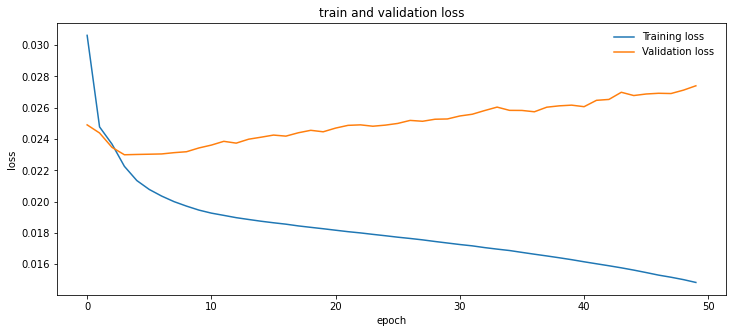

In [19]:
 #Rank 20
    lr = 1e-4
    epochs = 50
    batch_size = 256
    seed = 3
    verbose = 1
    r=20
    rank=r
    nc = rank
    set_session(device_count={"GPU": 0}, seed=seed)
    optim = k.optimizers.Adam(lr=lr)

    model = create_costco(shape, rank, nc)
    model.compile(optim, loss=["mse"], metrics=["mae", mape_keras])
    hists = model.fit(
    x=transform(tr_idxs),
    y=tr_vals,
    verbose=verbose,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=[k.callbacks.EarlyStopping(
        monitor="val_mean_absolute_error", 
        patience=10, 
        restore_best_weights=True)],
        );
    
    tr_info = get_metrics(model, transform(tr_idxs), tr_vals)
    te_info = get_metrics(model, transform(te_idxs), te_vals)
    pprint({'train': tr_info, 'test': te_info})
    cplot_loss(hists.history)


In [16]:
    #Rank 40
    lr = 1e-4
    epochs = 50
    batch_size = 256
    seed = 3
    verbose = 1
    r=40
    rank=r
    nc = rank
    set_session(device_count={"GPU": 0}, seed=seed)
    optim = k.optimizers.Adam(lr=lr)

    model = create_costco(shape, rank, nc)
    model.compile(optim, loss=["mse"], metrics=["mae", mape_keras])
    hists = model.fit(
    x=transform(tr_idxs),
    y=tr_vals,
    verbose=verbose,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=[k.callbacks.EarlyStopping(
        monitor="val_mean_absolute_error", 
        patience=10, 
        restore_best_weights=True)],
        );
    
    tr_info = get_metrics(model, transform(tr_idxs), tr_vals)
    te_info = get_metrics(model, transform(te_idxs), te_vals)
    pprint({'train': tr_info, 'test': te_info})
    cplot_loss(hists.history)
    

/home/dan/.local/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 85668 samples, validate on 9519 samples
Epoch 1/50
85668/85668 [==============================] - 2s 27us/step - loss: 0.0267 - mae: 0.0946 - mape_keras: 56.3458 - val_loss: 0.0244 - val_mae: 0.0908 - val_mape_keras: 55.8625
Epoch 2/50
 7168/85668 [=>............................] - ETA: 1s - loss: 0.0257 - mae: 0.0925 - mape_keras: 55.9256

/home/dan/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_mean_absolute_error` which is not available. Available metrics are: val_loss,val_mae,val_mape_keras,loss,mae,mape_keras
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


85668/85668 [==============================] - 2s 24us/step - loss: 0.0235 - mae: 0.0874 - mape_keras: 52.9161 - val_loss: 0.0232 - val_mae: 0.0837 - val_mape_keras: 49.6001
Epoch 3/50
85668/85668 [==============================] - 2s 24us/step - loss: 0.0220 - mae: 0.0832 - mape_keras: 50.3679 - val_loss: 0.0229 - val_mae: 0.0862 - val_mape_keras: 53.4605
Epoch 4/50
85668/85668 [==============================] - 2s 24us/step - loss: 0.0212 - mae: 0.0815 - mape_keras: 49.5246 - val_loss: 0.0228 - val_mae: 0.0851 - val_mape_keras: 52.2168
Epoch 5/50
85668/85668 [==============================] - 2s 24us/step - loss: 0.0206 - mae: 0.0794 - mape_keras: 47.8157 - val_loss: 0.0229 - val_mae: 0.0802 - val_mape_keras: 46.1329
Epoch 6/50
85668/85668 [==============================] - 2s 24us/step - loss: 0.0201 - mae: 0.0775 - mape_keras: 46.2278 - val_loss: 0.0231 - val_mae: 0.0835 - val_mape_keras: 50.2376
Epoch 7/50
85668/85668 [==============================] - 2s 24us/step - loss: 0.0196 

NameError: name 'cplot_loss' is not defined

/home/dan/.local/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 85668 samples, validate on 9519 samples
Epoch 1/50
85668/85668 [==============================] - 3s 41us/step - loss: 0.0257 - mae: 0.0925 - mape_keras: 55.4307 - val_loss: 0.0241 - val_mae: 0.0906 - val_mape_keras: 56.4590
Epoch 2/50
 4864/85668 [>.............................] - ETA: 2s - loss: 0.0224 - mae: 0.0869 - mape_keras: 53.6603

/home/dan/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_mean_absolute_error` which is not available. Available metrics are: val_loss,val_mae,val_mape_keras,loss,mae,mape_keras
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


85668/85668 [==============================] - 3s 38us/step - loss: 0.0230 - mae: 0.0855 - mape_keras: 51.6941 - val_loss: 0.0231 - val_mae: 0.0844 - val_mape_keras: 50.7614
Epoch 3/50
85668/85668 [==============================] - 3s 39us/step - loss: 0.0216 - mae: 0.0821 - mape_keras: 49.7180 - val_loss: 0.0231 - val_mae: 0.0856 - val_mape_keras: 52.5423
Epoch 4/50
85668/85668 [==============================] - 3s 39us/step - loss: 0.0209 - mae: 0.0805 - mape_keras: 48.6462 - val_loss: 0.0230 - val_mae: 0.0778 - val_mape_keras: 42.7907
Epoch 5/50
85668/85668 [==============================] - 3s 39us/step - loss: 0.0203 - mae: 0.0784 - mape_keras: 46.8962 - val_loss: 0.0232 - val_mae: 0.0815 - val_mape_keras: 47.4559
Epoch 6/50
85668/85668 [==============================] - 3s 39us/step - loss: 0.0199 - mae: 0.0772 - mape_keras: 45.9977 - val_loss: 0.0233 - val_mae: 0.0815 - val_mape_keras: 47.3517
Epoch 7/50
85668/85668 [==============================] - 3s 39us/step - loss: 0.0196 

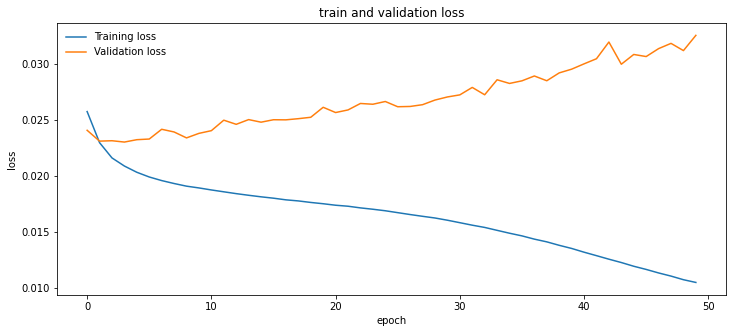

In [20]:
#Rank 40
    lr = 1e-4
    epochs = 50
    batch_size = 256
    seed = 3
    verbose = 1
    r=60
    rank=r
    nc = rank
    set_session(device_count={"GPU": 0}, seed=seed)
    optim = k.optimizers.Adam(lr=lr)

    model = create_costco(shape, rank, nc)
    model.compile(optim, loss=["mse"], metrics=["mae", mape_keras])
    hists = model.fit(
    x=transform(tr_idxs),
    y=tr_vals,
    verbose=verbose,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=[k.callbacks.EarlyStopping(
        monitor="val_mean_absolute_error", 
        patience=10, 
        restore_best_weights=True)],
        );
    
    tr_info = get_metrics(model, transform(tr_idxs), tr_vals)
    te_info = get_metrics(model, transform(te_idxs), te_vals)
    pprint({'train': tr_info, 'test': te_info})
    cplot_loss(hists.history)
    

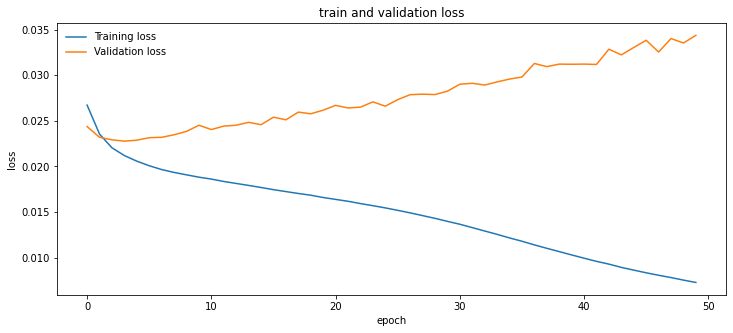

In [18]:
cplot_loss(hists.history)